# Urban Heat Island (UHI) Benchmark Notebook 

## Challenge Overview

<p align="justify">Welcome to the EY Open Science AI & Data Challenge 2025! The objective of this challenge is to build a machine learning model to predict urban heat island (UHI) hotspots in a city. By the end of the challenge, you will have developed a regression model capable of predicting the intensity of the UHI effect.

Participants will be given ground-level air temperature data in an index format, which was collected on 24th July 2021 on traverse points in the Bronx and Manhattan regions of New York city. This dataset constitutes traverse points (latitude and longitude) and their corresponding UHI (Urban Heat Island) index values. Participants will use this dataset to build a regression model to predict UHI index values for a given set of locations. It is important to understand that the UHI Index at any given location is indicative of the relative temperature elevation at that specific point compared to the city's average temperature.

This challenge is designed for participants with varying skill levels in data science and programming, offering a great opportunity to apply your knowledge and enhance your capabilities in the field.</p>

<b>Challenge Aim: </b><p align="justify"> <p>

<p align="justify">In this notebook, we will demonstrate a basic model workflow that can serve as a starting point for the challenge. The basic model has been constructed to predict the Urban Heat Island (UHI) index using features from the Sentinel-2 satellite dataset as predictor variables. In this demonstration, we utilized three features from the Sentinel-2 dataset: band B01 (Coastal Aerosol), band B06 (Red Edge), and NDVI (Normalized Difference Vegetation Index) derived from bands B04 (Red) and B08 (Near Infrared). A random forest regression model was then trained using these features.
    
These features were extracted from a GeoTIFF image created by the Sentinel-2 sample notebook. For the sample model shown in this notebook, data from a single day (24th July 2021) was considered, assuming that the values of bands B01, B04, B06, and B08 for this specific date are representative of the UHI index behavior at any location. Participants should review the details of the Sentinel-2 sample notebook to gain an understanding of the data and options for modifying the output product. 
    
</p>

<p align="justify">Most of the functions presented in this notebook were adapted from the <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook">Sentinel-2-Level-2A notebook</a> found in the Planetary Computer portal.</p>

<p align="justify">Please note that this notebook is just a starting point. We have made many assumptions in this notebook that you may think are not best for solving the challenge effectively. You are encouraged to modify these functions, rewrite them, or try an entirely new approach.</p>


## Load In Dependencies

To run this demonstration notebook, you will need to have the following packages imported below installed. This may take some time.  

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial raster data handling
import rioxarray as rxr

# Geospatial data analysis
import geopandas as gpd

# Geospatial operations
import rasterio
from rasterio import windows  
from rasterio import features  
from rasterio import warp
from rasterio.warp import transform_bounds 
from rasterio.windows import from_bounds 

# Image Processing
from PIL import Image

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Planetary Computer Tools
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo

# Others
import os
from tqdm import tqdm



## Response Variable

Before building the model, we need to load in the Urban Heat Island (UHI) index training dataset. We have curated data for the New York region. The dataset consists of geo-locations (Longitude and Latitude), with additional fields including date & time of data collection and the UHI index for each location. 

<h10 style="color:rgb(255, 255, 0)"><strong>Note: Participants are strictly prohibited from using Longitude and Latitude values as features in building their machine learning models. These values should only be utilized for understanding the attributes and characteristics of the locations. Submissions that employ longitude and latitude values as model features will be disqualified.</strong></h10>

<h10 style="color:rgb(255, 255, 0)"><strong>Incorporating latitude and longitude data in their raw forms or through any form of manipulation—including multiplication, embedding, or conversion to polar coordinates—as predictive features in your model is strictly prohibited, as it can compromise the adaptability of your model across diverse scenarios. This prohibition extends to calculating the distance from a reference point and using it as a feature, which is essentially a transformation of the original geographical coordinates into a new feature form. Submissions that include these types of features will be considered non-compliant and will be disqualified.</strong></h10>

In [2]:
# Load the training data from csv file and display the first few rows to inspect the data
ground_df = pd.read_csv("Training_data_uhi_index_2025-02-18.csv")
ground_df.head()

,Longitude,Latitude,datetime,UHI Index
0,-73.909167,40.813107,24-07-2021 15:53,1.030289
1,-73.909187,40.813045,24-07-2021 15:53,1.030289
2,-73.909215,40.812978,24-07-2021 15:53,1.023798
3,-73.909242,40.812908,24-07-2021 15:53,1.023798
4,-73.909257,40.812845,24-07-2021 15:53,1.021634


## Predictor Variables

<p align="justify">Now that we have our UHI data, it is time to gather the predictor variables from the Sentinel-2 dataset. Participants should review the provided Sentinel-2 sample notebook as it was used to create a sample GeoTIFF for this models. For a more in-depth look regarding the Sentinel-2 dataset and how to query it, see the Microsoft Planetary Computer example <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook">Sentinel-2 supplementary notebook</a>. </p>

<p align="justify">Sentinel-2 optical data provides high-resolution imagery that is sensitive to land surface characteristics, which are crucial for understanding urban heat dynamics. Band values such as B01 (Coastal aerosol), B06 (Red Edge), and NDVI (Normalized Difference Vegetation Index) derived from B04 (Red) and B08 (Near Infrared) help us in estimating the UHI index. Hence, we are choosing B01, B06, and NDVI as predictor variables for this experiment.</p>

<ul> 
<li>B01 - Reflectance values from the Coastal aerosol band, which help in assessing aerosol presence and improving atmospheric correction.</li>

<li>B06 - Reflectance values from the Red Edge band, which provide useful information for detecting vegetation, water bodies, and urban surfaces.</li>

<li>NDVI - Derived from B04 (Red) and B08 (Near Infrared), NDVI is an important indicator for vegetation health and land cover.</li>
</ul>








<h4 style="color:rgb(255, 255, 0)"><strong>Tip 1</strong></h4>
<p align="justify">Participants might explore other combinations of bands from the Sentinel-2 and from other satellite datasets as well. For example, you can use mathematical combinations of bands to generate various indices </a> which can then be used as features in your model. These bands or indices may provide insights into surface characteristics, vegetation, or built-up areas that could influence UHI patterns.

### Analyze the Sentinel-2 Data

<p align="justify">To obtain the Sentinel-2 data, we created a GeoTIFF image for a specific date and area of interest, which in this case is the Bronx and Manhattan regions of New York. The GeoTIFF product allows us to extract the relevant band values. In this example, we extracted B01 (Coastal Aerosol), B04 (Red), B06 (Red Edge), and B08 (Near Infrared) values for a single day (24th July, 2021). Participants should review the provided Sentinel-2 sample notebook for common output images (RGB, NDVI) and methods to alter the output.</p>

### Methods of Extracting Band Values from Sentinel-2 Data

There are two common methods to extract band values from Sentinel-2 data:

<ul>
    <li><strong>Using API Calls:</strong> Retrieve band values directly from Sentinel-2 datasets via APIs, such as the <code>planetary_computer</code>.</li>
</ul>
<ul>
    <li><strong>Using GeoTIFF Images:</strong> Create and download a GeoTIFF image containing the desired bands and extract the band values locally. The GeoTIFF image can represent any desired time period (single date or time series mosaic) and include any number of spectral bands.</li>
</ul>

Participants can select any of these approaches as per their convenience. Since our dataset is large, the API method can be time-consuming and resource-intensive. Therefore, in this sample notebook, we have opted for the second method and extracted the values for bands B01, B04, B08, and B06. Please refer to the Sentinel-2 sample notebook for details about the creation of the GeoTIFF image. 

<h4 style="color:rgb(255, 255, 0)"><strong>Tip 2</strong></h4>
<p align="justify"> Rather than extracting the bands for a single day coincident with the ground-based data collection, participants might explore other options to improve data quality. For example, one could select a different single date with minimal or no cloud cover or generate a median mosaic using several scenes within a time series. See the Sentinel-2 sample notebook for examples.</p>

### Downloading GeoTIFF Image

For building a sample model in this demonstration notebook, we have downloaded a GeoTIFF file locally for a single day (24th July 2021). The file is named <b>S2_sample.tiff</b>. This GeoTIFF file contains values of four bands: Band B01, Band B04, Band B06 and Band B08. In the subsequent section, we will use this GeoTIFF file to extract the band values for the geo-locations given in the training dataset to create the features.

First, let’s visualize the bands of the downloaded GeoTIFF image.

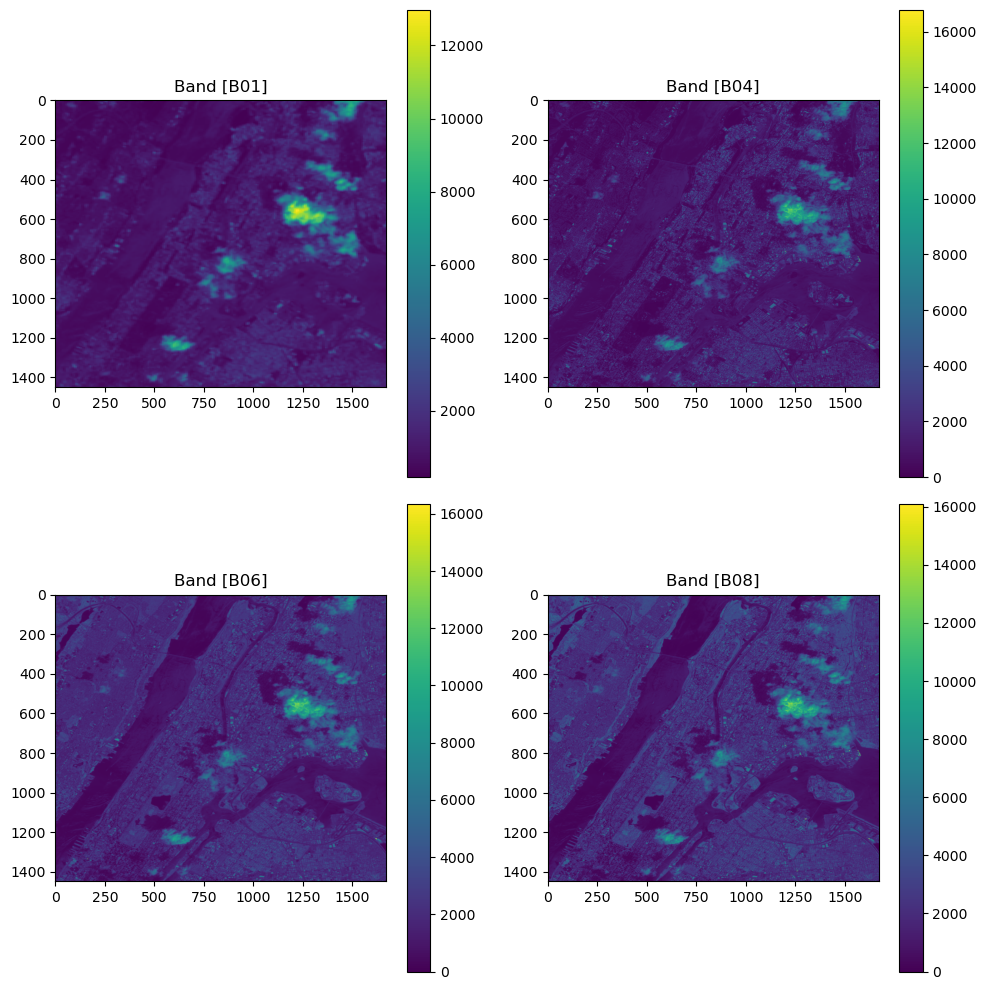

In [3]:
# Reads and plots four bands (B04, B08, B06, B01) from the GeoTIFF file.

# Open the GeoTIFF file
tiff_path = "S2_sample.tiff"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as src1:
    band1 = src1.read(1)  # Band [B01]
    band2 = src1.read(2)  # Band [B04]
    band3 = src1.read(3)  # Band [B06]
    band4 = src1.read(4)  # Band [B08]

# Plot the bands in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Plot the first band (B01)
im1 = axes[0].imshow(band1, cmap='viridis')
axes[0].set_title('Band [B01]')
fig.colorbar(im1, ax=axes[0])

# Plot the second band (B04)
im2 = axes[1].imshow(band2, cmap='viridis')
axes[1].set_title('Band [B04]')
fig.colorbar(im2, ax=axes[1])

# Plot the third band (B06)
im3 = axes[2].imshow(band3, cmap='viridis')                 
axes[2].set_title('Band [B06]')
fig.colorbar(im3, ax=axes[2])

# Plot the fourth band (B08)
im4 = axes[3].imshow(band4, cmap='viridis')
axes[3].set_title('Band [B08]')
fig.colorbar(im4, ax=axes[3])

plt.tight_layout()
plt.show()


<h4 style="color:rgb(255, 255, 0)"><strong>Tip 3</strong></h4>

Instead of a single point data extraction, participants might explore the approach of creating a focal buffer around the locations (e.g., 50 m, 100 m, 150 m etc). For example, if the specified distance was 50 m and the specified band was “Band 2”, then the value of the output pixels from this analysis would reflect the average values in band 2 within 50 meters of the specific location. This approach might help reduction in error associated with spatial autocorrelation. In this demonstration notebook, we are extracting the band data for each of the locations without creating a buffer zone.




### Extracting Band Values from the GeoTIFF Image


In [4]:
# Extracts satellite band values from a GeoTIFF based on coordinates from a csv file and returns them in a DataFrame.

def map_satellite_data(tiff_path, csv_path):
    
    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs

    # Read the Excel file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # 3. Convert lat/long to the GeoTIFF's CRS
    # Create a Proj object for EPSG:4326 (WGS84 - lat/long) and the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  # EPSG:4326 is the common lat/long CRS
    proj_tiff = Proj(tiff_crs)
    
    # Create a transformer object
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

    B01_values = []
    B04_values = []
    B06_values = []
    B08_values = []
    B11_values = []

# Iterate over the latitudes and longitudes, and extract the corresponding band values
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
    # Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)
    
        B01_value = data.sel(x=lon, y=lat,  band=1, method="nearest").values
        B01_values.append(B01_value)
    
        B04_value = data.sel(x=lon, y=lat, band=2, method="nearest").values
        B04_values.append(B04_value)
        
        B06_value = data.sel(x=lon, y=lat, band=3, method="nearest").values
        B06_values.append(B06_value)
    
        B08_value = data.sel(x=lon, y=lat, band=4, method="nearest").values
        B08_values.append(B08_value)

        B11_value = data.sel(x=lon, y=lat, band=5, method="nearest").values
        B11_values.append(B11_value)

    # Create a DataFrame with the band values
    # Create a DataFrame to store the band values
    df = pd.DataFrame()
    df['B01'] = B01_values
    df['B04'] = B04_values
    df['B06'] = B06_values
    df['B08'] = B08_values
    df['B11'] = B11_values
    
    
    return df


In [54]:
# # Extracts satellite band values from a GeoTIFF based on coordinates from a csv file and returns them in a DataFrame.

# from pyproj import Transformer
# import rioxarray as rxr
# import pandas as pd
# from tqdm import tqdm

# def map_satellite_data(tiff_path, csv_path):
    
#     # Load the GeoTIFF data
#     data = rxr.open_rasterio(tiff_path)
#     tiff_crs = data.rio.crs

#     # Load CSV with Latitude & Longitude
#     df = pd.read_csv(csv_path)
#     latitudes = df['Latitude'].values
#     longitudes = df['Longitude'].values

#     # Transformer: WGS84 (lat/lon) → TIFF CRS (UTM)
#     transformer = Transformer.from_crs("EPSG:4326", tiff_crs, always_xy=True)

#     B01_values = []
#     B04_values = []
#     B06_values = []
#     B08_values = []
#     B11_values = []

#     for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):

#         # Convert to UTM
#         x, y = transformer.transform(lon, lat)

#         # 🌟 IMPORTANT: use x,y (NOT lat/lon)
#         B01 = data.sel(band=1, x=x, y=y, method="nearest").values.item()
#         B04 = data.sel(band=2, x=x, y=y, method="nearest").values.item()
#         B06 = data.sel(band=3, x=x, y=y, method="nearest").values.item()
#         B08 = data.sel(band=4, x=x, y=y, method="nearest").values.item()
#         B11 = data.sel(band=5, x=x, y=y, method="nearest").values.item()

#         B01_values.append(B01)
#         B04_values.append(B04)
#         B06_values.append(B06)
#         B08_values.append(B08)
#         B11_values.append(B11)

#     # Output DataFrame
#     result = pd.DataFrame({
#         "Latitude": latitudes,
#         "Longitude": longitudes,
#         "B01": B01_values,
#         "B04": B04_values,
#         "B06": B06_values,
#         "B08": B08_values,
#         "B11": B11_values
#     })
    
#     return result


In [5]:
# Mapping satellite data with training data.
final_data = map_satellite_data('S2_sample_1.tiff', 'Training_data_uhi_index_2025-02-18.csv')

Mapping values: 100%|███████████████████████████████████████████████████████████| 11229/11229 [00:33<00:00, 334.47it/s]


In [6]:
final_data.head()

,B01,B04,B06,B08,B11
0,846.0,1036.0,1502.0,1906.0,1487.0
1,846.0,1036.0,1502.0,1906.0,1487.0
2,846.0,709.0,1668.0,2190.0,1465.0
3,846.0,657.0,1668.0,2182.0,1465.0
4,846.0,745.0,1728.0,2112.0,1544.0


In [7]:
# Calculate NDVI (Normalized Difference Vegetation Index) and handle division by zero by replacing infinities with NaN.
# See the Sentinel-2 sample notebook for more information about the NDVI index
final_data['NDVI'] = (final_data['B08'] - final_data['B04']) / (final_data['B08'] + final_data['B04'])
final_data['NDVI'] = final_data['NDVI'].replace([np.inf, -np.inf], np.nan) 

In [8]:
# NDBI (Built-Up Index)

final_data['NDBI'] = (final_data['B11'] - final_data['B08']) / (final_data['B11'] + final_data['B08'])
final_data['NDBI'] = final_data['NDBI'].replace([np.inf, -np.inf], np.nan)


In [9]:
# NDWI (Water Index – SWIR version)

final_data['NDWI'] = (final_data['B08'] - final_data['B11']) / (final_data['B08'] + final_data['B11'])
final_data['NDWI'] = final_data['NDWI'].replace([np.inf, -np.inf], np.nan)


In [10]:
# REVI (Red-Edge Vegetation Index)

final_data['REVI'] = (final_data['B06'] - final_data['B04']) / (final_data['B06'] + final_data['B04'])
final_data['REVI'] = final_data['REVI'].replace([np.inf, -np.inf], np.nan)


In [11]:
# . NDSI (SWIR Soil / Dryness Index)

final_data['NDSI'] = (final_data['B11'] - final_data['B04']) / (final_data['B11'] + final_data['B04'])
final_data['NDSI'] = final_data['NDSI'].replace([np.inf, -np.inf], np.nan)


In [12]:
# BSI (Bare Soil Index — simplified)

final_data['BSI'] = (final_data['B04'] - final_data['B08']) / (final_data['B04'] + final_data['B08'])
final_data['BSI'] = final_data['BSI'].replace([np.inf, -np.inf], np.nan)


In [13]:
final_data

,B01,B04,B06,B08,B11,NDVI,NDBI,NDWI,REVI,NDSI,BSI
0,846.0,1036.0,1502.0,1906.0,1487.0,0.295717,-0.123490,0.123490,0.183609,0.178755,-0.295717
1,846.0,1036.0,1502.0,1906.0,1487.0,0.295717,-0.123490,0.123490,0.183609,0.178755,-0.295717
2,846.0,709.0,1668.0,2190.0,1465.0,0.510866,-0.198358,0.198358,0.403450,0.347746,-0.510866
3,846.0,657.0,1668.0,2182.0,1465.0,0.537161,-0.196600,0.196600,0.434839,0.380773,-0.537161
4,846.0,745.0,1728.0,2112.0,1544.0,0.478474,-0.155361,0.155361,0.397493,0.349061,-0.478474
...,...,...,...,...,...,...,...,...,...,...,...
11224,481.0,528.0,2382.0,3284.0,1827.0,0.722980,-0.285071,0.285071,0.637113,0.551592,-0.722980
11225,481.0,610.0,2382.0,2900.0,1827.0,0.652422,-0.226994,0.226994,0.592246,0.499384,-0.652422
11226,481.0,610.0,2382.0,2900.0,1827.0,0.652422,-0.226994,0.226994,0.592246,0.499384,-0.652422
11227,481.0,610.0,2382.0,2900.0,1827.0,0.652422,-0.226994,0.226994,0.592246,0.499384,-0.652422


## Joining the predictor variables and response variables
Now that we have extracted our predictor variables, we need to join them onto the response variable . We use the function <i><b>combine_two_datasets</b></i> to combine the predictor variables and response variables.The <i><b>concat</b></i> function from pandas comes in handy here.

In [14]:
# Combine two datasets vertically (along columns) using pandas concat function.
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined 
    dataset2 - Dataset 2 to be combined
    '''
    
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [15]:
# Combining ground data and final data into a single dataset.
uhi_data = combine_two_datasets(ground_df,final_data)
uhi_data.head()

,Longitude,Latitude,datetime,UHI Index,B01,B04,B06,B08,B11,NDVI,NDBI,NDWI,REVI,NDSI,BSI
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,846.0,1036.0,1502.0,1906.0,1487.0,0.295717,-0.123490,0.123490,0.183609,0.178755,-0.295717
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,846.0,1036.0,1502.0,1906.0,1487.0,0.295717,-0.123490,0.123490,0.183609,0.178755,-0.295717
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,846.0,709.0,1668.0,2190.0,1465.0,0.510866,-0.198358,0.198358,0.403450,0.347746,-0.510866
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,846.0,657.0,1668.0,2182.0,1465.0,0.537161,-0.196600,0.196600,0.434839,0.380773,-0.537161
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,846.0,745.0,1728.0,2112.0,1544.0,0.478474,-0.155361,0.155361,0.397493,0.349061,-0.478474


In [16]:
# Extracted the data from the Lndsat satelite Tiff file

import rasterio
import geopandas as gpd
from shapely.geometry import Point
import numpy as np

# Convert uhi_data into geodataframe
geometry = [Point(xy) for xy in zip(uhi_data['Longitude'], uhi_data['Latitude'])]
uhi_gdf = gpd.GeoDataFrame(uhi_data, geometry=geometry, crs="EPSG:4326")

with rasterio.open("Landsat_LST.tiff") as src:
    uhi_gdf = uhi_gdf.to_crs(src.crs)
    band1 = src.read(1)
    
    lst_values = []
    for point in uhi_gdf.geometry:
        row, col = src.index(point.x, point.y)
        try:
            pixel = band1[row, col]
        except:
            pixel = np.nan
        
        if src.nodata is not None and pixel == src.nodata:
            pixel = np.nan
        
        lst_values.append(pixel)

uhi_gdf["LST"] = lst_values

uhi_data = pd.DataFrame(uhi_gdf)


In [17]:
uhi_data.head()

,Longitude,Latitude,datetime,UHI Index,B01,B04,B06,B08,B11,NDVI,NDBI,NDWI,REVI,NDSI,BSI,geometry,LST
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,846.0,1036.0,1502.0,1906.0,1487.0,0.295717,-0.123490,0.123490,0.183609,0.178755,-0.295717,POINT (-73.90917 40.81311),38.393941
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,846.0,1036.0,1502.0,1906.0,1487.0,0.295717,-0.123490,0.123490,0.183609,0.178755,-0.295717,POINT (-73.90919 40.81304),38.393941
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,846.0,709.0,1668.0,2190.0,1465.0,0.510866,-0.198358,0.198358,0.403450,0.347746,-0.510866,POINT (-73.90922 40.81298),37.785534
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,846.0,657.0,1668.0,2182.0,1465.0,0.537161,-0.196600,0.196600,0.434839,0.380773,-0.537161,POINT (-73.90924 40.81291),37.785534
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,846.0,745.0,1728.0,2112.0,1544.0,0.478474,-0.155361,0.155361,0.397493,0.349061,-0.478474,POINT (-73.90926 40.81284),37.358281


In [18]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import numpy as np

# ----------------------------------------------------------
# 1. LOAD UHI DATA (replace with your dataframe)
# ----------------------------------------------------------
# uhi_data must already have Latitude and Longitude columns
# Example: uhi_data = pd.read_csv("your_file.csv")

# Create points from lat/lon
uhi_data["geometry"] = uhi_data.apply(
    lambda row: Point(row["Longitude"], row["Latitude"]),
    axis=1
)

# Convert to GeoDataFrame in WGS84 (lat/lon)
uhi_gdf = gpd.GeoDataFrame(uhi_data, geometry="geometry", crs="EPSG:4326")

# ----------------------------------------------------------
# 2. LOAD BUILDING FOOTPRINTS (KML file)
# ----------------------------------------------------------
buildings = gpd.read_file("Building_Footprint.kml")

# KML files are usually in EPSG:4326; reproject to meters
buildings = buildings.to_crs(epsg=3857)

# Reproject UHI points to match
uhi_gdf = uhi_gdf.to_crs(epsg=3857)

# ----------------------------------------------------------
# 3. CREATE BUFFERS (50m, 100m, 200m)
# ----------------------------------------------------------
uhi_gdf["buffer_50"]  = uhi_gdf.geometry.buffer(50)
uhi_gdf["buffer_100"] = uhi_gdf.geometry.buffer(100)
uhi_gdf["buffer_200"] = uhi_gdf.geometry.buffer(200)

# ----------------------------------------------------------
# 4. BUILDING DENSITY (50m, 100m, 200m)
# ----------------------------------------------------------
density_50  = []
density_100 = []
density_200 = []

for i, row in uhi_gdf.iterrows():
    buf50  = row["buffer_50"]
    buf100 = row["buffer_100"]
    buf200 = row["buffer_200"]

    density_50.append(  buildings.intersects(buf50).sum() )
    density_100.append( buildings.intersects(buf100).sum() )
    density_200.append( buildings.intersects(buf200).sum() )

uhi_gdf["building_density_50"]  = density_50
uhi_gdf["building_density_100"] = density_100
uhi_gdf["building_density_200"] = density_200

# ----------------------------------------------------------
# 5. TOTAL BUILDING AREA (100m, 200m)
# ----------------------------------------------------------
area_100 = []
area_200 = []

for i, row in uhi_gdf.iterrows():
    buf100 = row["buffer_100"]
    buf200 = row["buffer_200"]

    # buildings intersecting the buffer
    clipped_100 = buildings.intersection(buf100)
    clipped_200 = buildings.intersection(buf200)

    # sum of polygon areas (in square meters)
    area_100.append(clipped_100.area.sum())
    area_200.append(clipped_200.area.sum())

uhi_gdf["building_area_100"] = area_100
uhi_gdf["building_area_200"] = area_200

# ----------------------------------------------------------
# 6. DISTANCE TO NEAREST BUILDING
# ----------------------------------------------------------
distances = []

for pt in uhi_gdf.geometry:
    distances.append(buildings.distance(pt).min())

uhi_gdf["distance_to_building"] = distances

# ----------------------------------------------------------
# 7. BUILDING COVERAGE RATIO (100m buffer)
# ----------------------------------------------------------
# buffer area = π * r^2 = 3.14159 * 100^2
buffer_area_100 = np.pi * (100 ** 2)

uhi_gdf["coverage_ratio_100"] = uhi_gdf["building_area_100"] / buffer_area_100

# ----------------------------------------------------------
# 8. CLEAN UP (OPTIONAL)
# ----------------------------------------------------------
# Drop the huge buffer geometry columns to save memory
uhi_gdf = uhi_gdf.drop(columns=["buffer_50", "buffer_100", "buffer_200"])

# Convert back to dataframe if needed
uhi_data_final = pd.DataFrame(uhi_gdf)

print("Building features successfully extracted!")


Building features successfully extracted!


In [19]:
uhi_data_final.head()

,Longitude,Latitude,datetime,UHI Index,B01,B04,B06,B08,B11,NDVI,...,BSI,geometry,LST,building_density_50,building_density_100,building_density_200,building_area_100,building_area_200,distance_to_building,coverage_ratio_100
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,846.0,1036.0,1502.0,1906.0,1487.0,0.295717,...,-0.295717,POINT (-8227530.799 4984813.901),38.393941,2,6,20,9532.859890,42252.080899,16.510178,0.303440
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,846.0,1036.0,1502.0,1906.0,1487.0,0.295717,...,-0.295717,POINT (-8227533.025 4984804.83),38.393941,1,6,18,9787.472852,41790.238634,16.641959,0.311545
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,846.0,709.0,1668.0,2190.0,1465.0,0.510866,...,-0.510866,POINT (-8227536.179 4984795.024),37.785534,2,6,18,10096.787015,41371.065679,17.537227,0.321391
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,846.0,657.0,1668.0,2182.0,1465.0,0.537161,...,-0.537161,POINT (-8227539.148 4984784.729),37.785534,2,5,20,10371.259772,41399.444459,18.143467,0.330127
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,846.0,745.0,1728.0,2112.0,1544.0,0.478474,...,-0.478474,POINT (-8227540.817 4984775.414),37.358281,2,5,19,10430.499264,42025.087257,14.128613,0.332013


In [20]:
print(uhi_data_final.columns.tolist())


['Longitude', 'Latitude', 'datetime', 'UHI Index', 'B01', 'B04', 'B06', 'B08', 'B11', 'NDVI', 'NDBI', 'NDWI', 'REVI', 'NDSI', 'BSI', 'geometry', 'LST', 'building_density_50', 'building_density_100', 'building_density_200', 'building_area_100', 'building_area_200', 'distance_to_building', 'coverage_ratio_100']


In [21]:
import pandas as pd
import numpy as np
from shapely.geometry import Point
import geopandas as gpd

# ---------------------------------------------------------
# 0. FIX UHI DATETIME FIRST
# ---------------------------------------------------------
uhi_data_final["datetime"] = pd.to_datetime(
    uhi_data_final["datetime"],
    dayfirst=True,       # IMPORTANT: your format is DD-MM-YYYY
    errors="coerce"
)

# ---------------------------------------------------------
# 1. Load Bronx & Manhattan weather sheets
# ---------------------------------------------------------
weather_bronx = pd.read_excel("NY_Mesonet_Weather.xlsx", sheet_name="Bronx")
weather_manh  = pd.read_excel("NY_Mesonet_Weather.xlsx", sheet_name="Manhattan")

# ---------------------------------------------------------
# 2. Clean weather data formatting
# ---------------------------------------------------------
def clean_weather(df, station_name):
    df = df.rename(columns={
        "Date / Time": "weather_datetime",
        "Relative Humidity [percent]": "humidity",
        "Avg Wind Speed [m/s]": "wind_speed",
        "Wind Direction [degrees]": "wind_direction",
        "Solar Flux [W/m^2]": "solar_flux"
    })
    df["weather_datetime"] = pd.to_datetime(df["weather_datetime"], errors="coerce")
    df["station"] = station_name
    return df

weather_bronx = clean_weather(weather_bronx, "Bronx")
weather_manh  = clean_weather(weather_manh, "Manhattan")

# Combine both stations
weather_all = pd.concat([weather_bronx, weather_manh], ignore_index=True)
weather_all = weather_all.sort_values("weather_datetime").reset_index(drop=True)

# ---------------------------------------------------------
# 3. Convert UHI to GeoDataFrame (for station distance)
# ---------------------------------------------------------
uhi_gdf = gpd.GeoDataFrame(
    uhi_data_final,
    geometry=gpd.points_from_xy(uhi_data_final["Longitude"], uhi_data_final["Latitude"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)

# ---------------------------------------------------------
# 4. HARD-CODED Mesonet station coordinates (correct!)
# ---------------------------------------------------------
bronx_point = gpd.GeoSeries(
    [Point(-73.8420, 40.8699)], 
    crs="EPSG:4326"
).to_crs(epsg=3857).iloc[0]

manh_point = gpd.GeoSeries(
    [Point(-73.9661, 40.7825)], 
    crs="EPSG:4326"
).to_crs(epsg=3857).iloc[0]

# ---------------------------------------------------------
# 5. Assign nearest station (Bronx or Manhattan)
# ---------------------------------------------------------
def choose_station(pt):
    if pt.distance(bronx_point) < pt.distance(manh_point):
        return "Bronx"
    else:
        return "Manhattan"

uhi_gdf["nearest_station"] = uhi_gdf.geometry.apply(choose_station)

# ---------------------------------------------------------
# 6. Merge weather by nearest timestamp FROM that station
# ---------------------------------------------------------
weather_vars = ["wind_speed", "wind_direction", "humidity", "solar_flux"]

def get_weather(row):
    st = row["nearest_station"]
    t = row["datetime"]

    df_st = weather_all[weather_all["station"] == st]

    # Find closest timestamp
    idx = (df_st["weather_datetime"] - t).abs().idxmin()

    return df_st.loc[idx, weather_vars]

weather_data = uhi_gdf.apply(get_weather, axis=1)

# ---------------------------------------------------------
# 7. Attach weather features
# ---------------------------------------------------------
uhi_gdf[weather_vars] = weather_data.values

# ---------------------------------------------------------
# 8. Convert back to DataFrame
# ---------------------------------------------------------
uhi_data_final = pd.DataFrame(uhi_gdf.drop(columns=["geometry"]))

print("🌤️ WEATHER MERGE SUCCESSFUL!")
uhi_data_final.head()


🌤️ WEATHER MERGE SUCCESSFUL!


,Longitude,Latitude,datetime,UHI Index,B01,B04,B06,B08,B11,NDVI,...,building_density_200,building_area_100,building_area_200,distance_to_building,coverage_ratio_100,nearest_station,wind_speed,wind_direction,humidity,solar_flux
0,-73.909167,40.813107,2021-07-24 15:53:00,1.030289,846.0,1036.0,1502.0,1906.0,1487.0,0.295717,...,20,9532.859890,42252.080899,16.510178,0.303440,Manhattan,3.4,196.0,46.7,605.0
1,-73.909187,40.813045,2021-07-24 15:53:00,1.030289,846.0,1036.0,1502.0,1906.0,1487.0,0.295717,...,18,9787.472852,41790.238634,16.641959,0.311545,Manhattan,3.4,196.0,46.7,605.0
2,-73.909215,40.812978,2021-07-24 15:53:00,1.023798,846.0,709.0,1668.0,2190.0,1465.0,0.510866,...,18,10096.787015,41371.065679,17.537227,0.321391,Manhattan,3.4,196.0,46.7,605.0
3,-73.909242,40.812908,2021-07-24 15:53:00,1.023798,846.0,657.0,1668.0,2182.0,1465.0,0.537161,...,20,10371.259772,41399.444459,18.143467,0.330127,Manhattan,3.4,196.0,46.7,605.0
4,-73.909257,40.812845,2021-07-24 15:53:00,1.021634,846.0,745.0,1728.0,2112.0,1544.0,0.478474,...,19,10430.499264,42025.087257,14.128613,0.332013,Manhattan,3.4,196.0,46.7,605.0


In [152]:
print(uhi_data_final.columns.tolist())

['Longitude', 'Latitude', 'datetime', 'UHI Index', 'B01', 'B04', 'B06', 'B08', 'B11', 'NDVI', 'NDBI', 'NDWI', 'REVI', 'NDSI', 'BSI', 'LST', 'building_density_50', 'building_density_100', 'building_density_200', 'building_area_100', 'building_area_200', 'distance_to_building', 'coverage_ratio_100', 'nearest_station', 'wind_speed', 'wind_direction', 'humidity', 'solar_flux']


In [153]:
uhi_data_final[uhi_data_final['nearest_station'] == 'Bronx'].head()

,Longitude,Latitude,datetime,UHI Index,B01,B04,B06,B08,B11,NDVI,...,building_density_200,building_area_100,building_area_200,distance_to_building,coverage_ratio_100,nearest_station,wind_speed,wind_direction,humidity,solar_flux
2952,-73.924678,40.843028,2021-07-24 15:46:00,0.980043,1272.0,812.0,1630.0,1180.0,2155.0,0.184739,...,18,11696.916113,43559.457710,4.119499,0.372324,Bronx,3.5,146.0,47.4,646.0
2953,-73.924647,40.843155,2021-07-24 15:46:00,0.982206,1272.0,704.0,1453.0,1034.0,1804.0,0.189873,...,16,12122.855736,40608.006527,2.496133,0.385882,Bronx,3.5,146.0,47.4,646.0
2954,-73.924642,40.843213,2021-07-24 15:46:00,0.982206,1272.0,1032.0,1453.0,1544.0,1804.0,0.198758,...,16,12347.848749,38852.889485,2.476611,0.393044,Bronx,3.5,146.0,47.4,646.0
2955,-73.924637,40.843263,2021-07-24 15:46:00,0.980043,1272.0,1032.0,1453.0,1544.0,1804.0,0.198758,...,15,12686.388610,37452.145611,5.326707,0.403820,Bronx,3.5,146.0,47.4,646.0
2956,-73.924625,40.843337,2021-07-24 15:46:00,0.980043,1272.0,1572.0,2022.0,2070.0,1978.0,0.136738,...,14,13155.874965,35478.991866,15.715868,0.418765,Bronx,3.5,146.0,47.4,646.0


In [22]:
uhi_data_final.head()

,Longitude,Latitude,datetime,UHI Index,B01,B04,B06,B08,B11,NDVI,...,building_density_200,building_area_100,building_area_200,distance_to_building,coverage_ratio_100,nearest_station,wind_speed,wind_direction,humidity,solar_flux
0,-73.909167,40.813107,2021-07-24 15:53:00,1.030289,846.0,1036.0,1502.0,1906.0,1487.0,0.295717,...,20,9532.859890,42252.080899,16.510178,0.303440,Manhattan,3.4,196.0,46.7,605.0
1,-73.909187,40.813045,2021-07-24 15:53:00,1.030289,846.0,1036.0,1502.0,1906.0,1487.0,0.295717,...,18,9787.472852,41790.238634,16.641959,0.311545,Manhattan,3.4,196.0,46.7,605.0
2,-73.909215,40.812978,2021-07-24 15:53:00,1.023798,846.0,709.0,1668.0,2190.0,1465.0,0.510866,...,18,10096.787015,41371.065679,17.537227,0.321391,Manhattan,3.4,196.0,46.7,605.0
3,-73.909242,40.812908,2021-07-24 15:53:00,1.023798,846.0,657.0,1668.0,2182.0,1465.0,0.537161,...,20,10371.259772,41399.444459,18.143467,0.330127,Manhattan,3.4,196.0,46.7,605.0
4,-73.909257,40.812845,2021-07-24 15:53:00,1.021634,846.0,745.0,1728.0,2112.0,1544.0,0.478474,...,19,10430.499264,42025.087257,14.128613,0.332013,Manhattan,3.4,196.0,46.7,605.0


## Removing duplicates
Identical or duplicate entries are removed based on specific columns, in our case [ 'B01','B04','B06','B08','NDVI']. This ensures that the dataset is not biased or skewed by repetitive data, allowing the model to train on unique, relevant observations.

In [28]:
print(uhi_data_final.columns.tolist())

['Longitude', 'Latitude', 'datetime', 'UHI Index', 'B01', 'B04', 'B06', 'B08', 'B11', 'NDVI', 'NDBI', 'NDWI', 'REVI', 'NDSI', 'BSI', 'LST', 'building_density_50', 'building_density_100', 'building_density_200', 'building_area_100', 'building_area_200', 'distance_to_building', 'coverage_ratio_100', 'nearest_station', 'wind_speed', 'wind_direction', 'humidity', 'solar_flux']


In [29]:
# Remove duplicate rows from the DataFrame based on specified columns and keep the first occurrence
columns_to_check = ['B01','B04','B06','B08','NDVI','NDBI','NDWI','REVI','NDSI','BSI','LST', 'building_density_50', 
                    'building_density_100', 'building_density_200', 'building_area_100', 'building_area_200', 
                    'distance_to_building', 'coverage_ratio_100', 'nearest_station', 'wind_speed', 'wind_direction', 'humidity', 'solar_flux']
for col in columns_to_check:
    # Check if the value is a numpy array and has more than one dimension
    uhi_data_final[col] = uhi_data_final[col].apply(lambda x: tuple(x) if isinstance(x, np.ndarray) and x.ndim > 0 else x)

# Now remove duplicates
uhi_data_final = uhi_data_final.drop_duplicates(subset=columns_to_check, keep='first')
uhi_data.head()


,Longitude,Latitude,datetime,UHI Index,B01,B04,B06,B08,B11,NDVI,NDBI,NDWI,REVI,NDSI,BSI,geometry,LST
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,846.0,1036.0,1502.0,1906.0,1487.0,0.295717,-0.123490,0.123490,0.183609,0.178755,-0.295717,POINT (-73.90916667 40.81310667),38.393941
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,846.0,1036.0,1502.0,1906.0,1487.0,0.295717,-0.123490,0.123490,0.183609,0.178755,-0.295717,POINT (-73.90918667 40.813045),38.393941
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,846.0,709.0,1668.0,2190.0,1465.0,0.510866,-0.198358,0.198358,0.403450,0.347746,-0.510866,POINT (-73.909215 40.81297833),37.785534
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,846.0,657.0,1668.0,2182.0,1465.0,0.537161,-0.196600,0.196600,0.434839,0.380773,-0.537161,POINT (-73.90924167 40.81290833),37.785534
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,846.0,745.0,1728.0,2112.0,1544.0,0.478474,-0.155361,0.155361,0.397493,0.349061,-0.478474,POINT (-73.90925667 40.812845),37.358281


In [30]:
uhi_data_final.shape

(11229, 28)

In [31]:
# Resetting the index of the dataset
uhi_data_final=uhi_data_final.reset_index(drop=True)

## Model Building

<p align="justify"> Now let us select the columns required for our model building exercise. We will consider only Band B01, Band B06 and NDVI from the Sentinel-2 data as our predictor variables. It does not make sense to use latitude and longitude as predictor variables, as they do not have any direct impact on predicting the UHI index.</p>


In [32]:
coords = uhi_data_final[['Longitude', 'Latitude']]
features = uhi_data_final[['B01','B04','B06','B08','NDVI','NDBI','NDWI','REVI',
                           'NDSI','BSI','LST', 
                           'building_density_50', 'building_density_100', 'building_density_200',
                           'building_area_100', 'building_area_200', 'distance_to_building',
                           'coverage_ratio_100', 'wind_speed','wind_direction','humidity','solar_flux']]

In [33]:
# !pip install lightgbm


In [34]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Step 1: Features and target
X = features.values
y = uhi_data_final['UHI Index'].values

# Step 2: Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123
)

# Step 3: Model
model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=123
)

# Step 4: Train
model.fit(X_train, y_train)

# Step 5: Predict
y_pred = model.predict(X_test)

# Step 6: Evaluate
from sklearn.metrics import mean_squared_error
import math

rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4005
[LightGBM] [Info] Number of data points in the train set: 7860, number of used features: 22
[LightGBM] [Info] Start training from score 1.000140
RMSE: 0.006306073244624327


In [35]:
# Retaining only the columns for B01, B06, NDVI, and UHI Index in the dataset.
uhi_data_final = uhi_data_final[['B01','B04','B06','B08','NDVI','NDBI','NDWI','REVI','NDSI','BSI','LST', 'building_density_50', 
                    'building_density_100', 'building_density_200', 'building_area_100', 'building_area_200', 
                    'distance_to_building', 'coverage_ratio_100', 'wind_speed', 'wind_direction', 'humidity', 'solar_flux','UHI Index']]

In [36]:
uhi_data_final.head()

,B01,B04,B06,B08,NDVI,NDBI,NDWI,REVI,NDSI,BSI,...,building_density_200,building_area_100,building_area_200,distance_to_building,coverage_ratio_100,wind_speed,wind_direction,humidity,solar_flux,UHI Index
0,846.0,1036.0,1502.0,1906.0,0.295717,-0.123490,0.123490,0.183609,0.178755,-0.295717,...,20,9532.859890,42252.080899,16.510178,0.303440,3.4,196.0,46.7,605.0,1.030289
1,846.0,1036.0,1502.0,1906.0,0.295717,-0.123490,0.123490,0.183609,0.178755,-0.295717,...,18,9787.472852,41790.238634,16.641959,0.311545,3.4,196.0,46.7,605.0,1.030289
2,846.0,709.0,1668.0,2190.0,0.510866,-0.198358,0.198358,0.403450,0.347746,-0.510866,...,18,10096.787015,41371.065679,17.537227,0.321391,3.4,196.0,46.7,605.0,1.023798
3,846.0,657.0,1668.0,2182.0,0.537161,-0.196600,0.196600,0.434839,0.380773,-0.537161,...,20,10371.259772,41399.444459,18.143467,0.330127,3.4,196.0,46.7,605.0,1.023798
4,846.0,745.0,1728.0,2112.0,0.478474,-0.155361,0.155361,0.397493,0.349061,-0.478474,...,19,10430.499264,42025.087257,14.128613,0.332013,3.4,196.0,46.7,605.0,1.021634


### Train and Test Split 

In [37]:
uhi_data_final.to_csv("uhi_data_final.csv", index=False)


In [38]:
uhi_data_final.columns

Index(['B01', 'B04', 'B06', 'B08', 'NDVI', 'NDBI', 'NDWI', 'REVI', 'NDSI',
       'BSI', 'LST', 'building_density_50', 'building_density_100',
       'building_density_200', 'building_area_100', 'building_area_200',
       'distance_to_building', 'coverage_ratio_100', 'wind_speed',
       'wind_direction', 'humidity', 'solar_flux', 'UHI Index'],
      dtype='object')

<p align="justify">We will now split the data into 70% training data and 30% test data. Scikit-learn alias “sklearn” is a robust library for machine learning in Python. The scikit-learn library has a <i><b>model_selection</b></i> module in which there is a splitting function <i><b>train_test_split</b></i>. You can use the same.</p>

Once you are satisfied with your model, you can proceed to make a submission. To do this, you will need to use your model to predict the Urban Heat Island (UHI) index for a set of test coordinates provided in the <b>"Submission_template.csv"</b> file and upload the results to the challenge platform.

In [141]:
#Reading the coordinates for the submission
test_file = pd.read_csv('Submission_template.csv')
test_file.head()

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,NaN
1,-73.971928,40.788875,NaN
2,-73.967080,40.789080,NaN
3,-73.972550,40.789082,NaN
4,-73.969697,40.787953,NaN


In [37]:
# Mapping satellite data for submission.
val_data = map_satellite_data('S2_sample.tiff', 'Submission_template.csv')

Mapping values: 100%|█████████████████████████████████████████████████████████████| 1040/1040 [00:02<00:00, 368.80it/s]


In [38]:
# Calculate NDVI (Normalized Difference Vegetation Index) and handle division by zero by replacing infinities with NaN.
val_data['NDVI'] = (val_data['B08'] - val_data['B04']) / (val_data['B08'] + val_data['B04'])
val_data['NDVI'] = val_data['NDVI'].replace([np.inf, -np.inf], np.nan)  # Replace infinities with NaN

In [39]:
val_data.head()

,B01,B04,B06,B08,NDVI
0,811.0,432.0,2089.0,2502.0,0.705521
1,1208.0,647.0,2076.0,2906.0,0.635801
2,899.0,1188.0,995.0,1246.0,0.023829
3,1193.0,1512.0,1939.0,1774.0,0.079732
4,1097.0,1688.0,2204.0,2834.0,0.253428


In [40]:
# Extracting specific columns (B01, B06, and NDVI) from the validation dataset
submission_val_data=val_data.loc[:,['B01','B06','NDVI']]
submission_val_data.head()

,B01,B06,NDVI
0,811.0,2089.0,0.705521
1,1208.0,2076.0,0.635801
2,899.0,995.0,0.023829
3,1193.0,1939.0,0.079732
4,1097.0,2204.0,0.253428


In [41]:
# Feature Scaling 
submission_val_data = submission_val_data.values
transformed_submission_data = sc.transform(submission_val_data)

In [42]:
#Making predictions
final_predictions = model.predict(transformed_submission_data)
final_prediction_series = pd.Series(final_predictions)

In [43]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'Longitude':test_file['Longitude'].values, 'Latitude':test_file['Latitude'].values, 'UHI Index':final_prediction_series.values})

In [44]:
#Displaying the sample submission dataframe
submission_df.head()

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,0.969207
1,-73.971928,40.788875,0.977333
2,-73.967080,40.789080,1.000949
3,-73.972550,40.789082,1.006940
4,-73.969697,40.787953,0.964487
